# XGBoost Model Training and Comparisons

## Data Load and Base Functions

In [1]:
import pandas as pd
import numpy as np

In [37]:
df = pd.read_parquet("data_raw_2021/costco_2021_reviews_filtered_vectorized_master_en_float32_nodup.parquet")
df.drop(columns=["pics", "resp"], inplace=True)

In [21]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from xgboost import XGBClassifier
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns

import time

In [38]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=123, stratify=df["rating"])

In [39]:
X_train = pd.DataFrame(np.vstack(df_train["vector"].tolist()))
y_train = df_train["rating"]

In [73]:
# Simplified cross_validate with built-in undersampler
def cross_validate(model, X, y, downsample=False, random_state=123, sample_weight=None, n_splits=11):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    sampler = RandomUnderSampler(random_state=random_state)

    results = {"confusion": [], "accuracy": [], "log_loss": []}

    for i, (train_indices, test_indices) in enumerate(cv.split(X, y)):
        start = time.time()
        print(f"CV split: {i}", end="\t")

        X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
        X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]

        if downsample:
            X_train, y_train = sampler.fit_resample(X_train, y_train)

        weights = sample_weight.iloc[train_indices] if sample_weight is not None else None
        model.fit(X_train, y_train, sample_weight=weights)
        y_pred = model.predict(X_test)

        results["confusion"].append(confusion_matrix(y_test, y_pred, normalize="true"))
        results["accuracy"].append(accuracy_score(y_test, y_pred))
        results["log_loss"].append(log_loss(y_test, model.predict_proba(X_test)))

        elapsed = time.time() - start
        print(f"Time Elapsed: {elapsed // 60:.0f}m {elapsed % 60:.0f}s")

    return results

In [45]:
def show_cv_results(results):
    print("Average CV Accuracy:      \t", np.array(results["accuracy"]).mean())
    print("Average CV Cross-Entropy: \t", np.array(results["log_loss"]).mean())

    ax = sns.heatmap(
        np.mean(results["confusion"], axis=0), annot=True,
        yticklabels=list(range(1, 6)),
        xticklabels=list(range(1, 6)),
        cmap="viridis", vmin=0.0, vmax=1.0,
    )
    ax.set(xlabel="Predicted Label", ylabel="True Label")

In [52]:
def cross_validate_params(model, param_name, param_list, X, y, **kwargs):
    result_list = []
    for param in param_list:
        print(f"[{param_name} = {param}]")
        model.set_params(**{param_name: param})
        result_list.append(cross_validate(model, X, y, **kwargs))

    return result_list

## Baseline Model (Logistic Regression)

### No downsampling

In [155]:
model = LogisticRegression(solver="newton-cg")
results = cross_validate(model, X_train, y_train)

CV split: 0	Time Elapsed: 1m 51s
CV split: 1	Time Elapsed: 2m 45s
CV split: 2	Time Elapsed: 2m 48s
CV split: 3	Time Elapsed: 1m 5s
CV split: 4	Time Elapsed: 2m 51s
CV split: 5	Time Elapsed: 1m 60s
CV split: 6	Time Elapsed: 1m 6s
CV split: 7	Time Elapsed: 2m 54s
CV split: 8	Time Elapsed: 1m 50s
CV split: 9	Time Elapsed: 2m 32s
CV split: 10	Time Elapsed: 1m 38s


Average CV Accuracy:      	 0.7427513254582795
Average CV Cross-Entropy: 	 0.6502856411951634


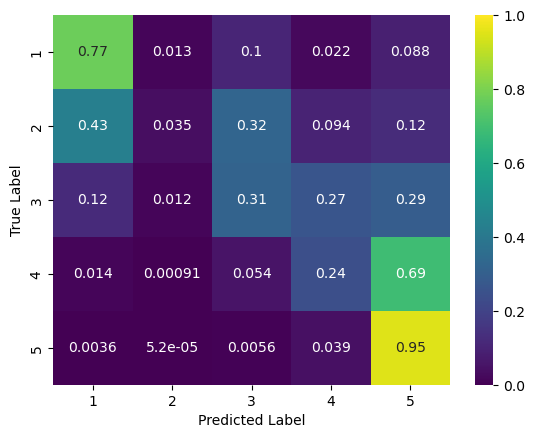

In [156]:
show_cv_results(results)

In [174]:
y_train.value_counts(normalize=True)

rating
5    0.669414
4    0.195852
3    0.061189
1    0.049704
2    0.023841
Name: proportion, dtype: float64

For reference, always predicting the most common rating (5-stars) has accuracy $\simeq 66\%$.

### Downsampled to minority class

In [151]:
model = LogisticRegression(solver="newton-cg")
results = cross_validate(model, X_train, y_train, downsample=True)

CV split: 0	Time Elapsed: 0m 6s
CV split: 1	Time Elapsed: 0m 5s
CV split: 2	Time Elapsed: 0m 4s
CV split: 3	Time Elapsed: 0m 4s
CV split: 4	Time Elapsed: 0m 4s
CV split: 5	Time Elapsed: 0m 4s
CV split: 6	Time Elapsed: 0m 4s
CV split: 7	Time Elapsed: 0m 5s
CV split: 8	Time Elapsed: 0m 4s
CV split: 9	Time Elapsed: 0m 5s
CV split: 10	Time Elapsed: 0m 4s


Average CV Accuracy:      	 0.6402366444665734
Average CV Cross-Entropy: 	 0.8879685761920656


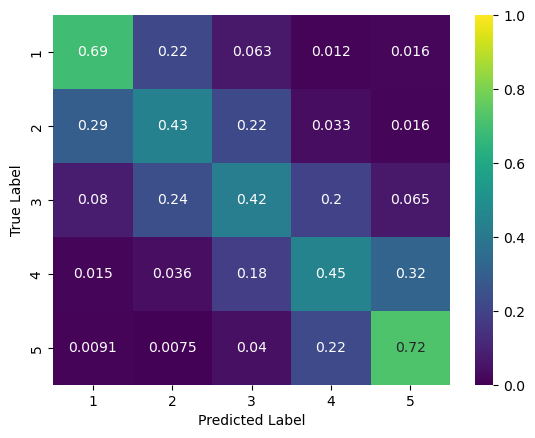

In [154]:
show_cv_results(results)

Downsampling makes off-by-2 errors much less common, but decreases overall accuracy by missclassifying the most common ratings more often.

## XGBClassifier

### Downsampled to minority class

In [157]:
xgb_downsample = XGBClassifier()
xgb_downsample_results = cross_validate(xgb_downsample, X_train, y_train - 1, downsample=True)

CV split: 0	Time Elapsed: 0m 52s
CV split: 1	Time Elapsed: 0m 50s
CV split: 2	Time Elapsed: 0m 51s
CV split: 3	Time Elapsed: 0m 51s
CV split: 4	Time Elapsed: 0m 52s
CV split: 5	Time Elapsed: 0m 54s
CV split: 6	Time Elapsed: 1m 0s
CV split: 7	Time Elapsed: 1m 1s
CV split: 8	Time Elapsed: 1m 1s
CV split: 9	Time Elapsed: 1m 1s
CV split: 10	Time Elapsed: 1m 3s


Average CV Accuracy:      	 0.6106460779798432
Average CV Cross-Entropy: 	 0.9247186162487779


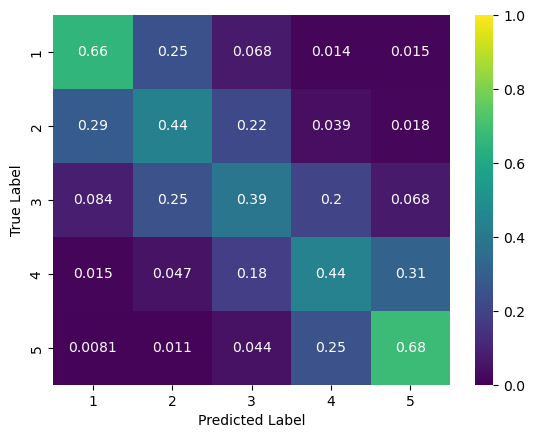

In [158]:
show_cv_results(xgb_downsample_results)

### No downsampling

In [159]:
xgb_std = XGBClassifier()
xgb_std_results = cross_validate(xgb_std, X_train, y_train - 1)

CV split: 0	Time Elapsed: 5m 15s
CV split: 1	Time Elapsed: 6m 14s
CV split: 2	Time Elapsed: 6m 31s
CV split: 3	Time Elapsed: 6m 29s
CV split: 4	Time Elapsed: 5m 44s
CV split: 5	Time Elapsed: 5m 47s
CV split: 6	Time Elapsed: 5m 48s
CV split: 7	Time Elapsed: 5m 49s
CV split: 8	Time Elapsed: 5m 53s
CV split: 9	Time Elapsed: 5m 54s
CV split: 10	Time Elapsed: 5m 57s


Average CV Accuracy:      	 0.7402379023972059
Average CV Cross-Entropy: 	 0.6543799190294395


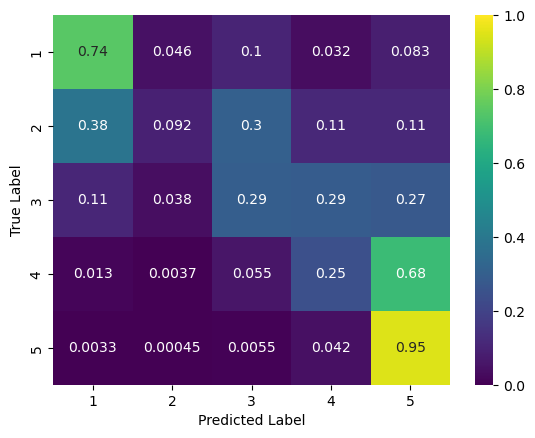

In [160]:
show_cv_results(xgb_std_results)

### Using sample weights

In [162]:
class_weights = (y_train.value_counts().min() / y_train.value_counts()).sort_index()
weights = y_train.apply(lambda r: class_weights[r])

In [173]:
xgb_weighted_std = XGBClassifier()
xgb_weighted_std_results = cross_validate(xgb_weighted_std, X_train, y_train - 1, sample_weight=weights)

CV split: 0	Time Elapsed: 4m 22s
CV split: 1	Time Elapsed: 5m 52s
CV split: 2	Time Elapsed: 6m 16s
CV split: 3	Time Elapsed: 6m 23s
CV split: 4	Time Elapsed: 6m 32s
CV split: 5	Time Elapsed: 6m 25s
CV split: 6	Time Elapsed: 6m 2s
CV split: 7	Time Elapsed: 6m 41s
CV split: 8	Time Elapsed: 7m 2s
CV split: 9	Time Elapsed: 6m 59s
CV split: 10	Time Elapsed: 7m 3s


Average CV Accuracy:      	 0.6469797739147526
Average CV Cross-Entropy: 	 0.8487341584967782


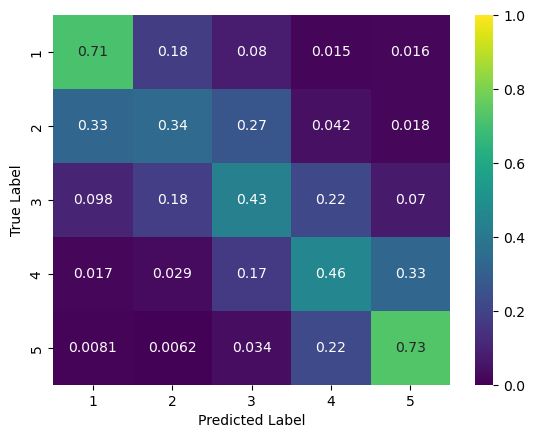

In [176]:
show_cv_results(xgb_weighted_std_results)

Similar to undersampling but with slightly better accuracy and longer training time.

In [39]:
xgb_exp = XGBClassifier(
    min_child_weight=2,
    max_depth=10,
    subsample=0.7,
    colsample_bytree=0.3,
    n_estimators=300,
)
sampler = RandomUnderSampler(random_state=123)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

xgb_exp_confusion = []
xgb_exp_acc = []
xgb_exp_log_loss = []

for i, (train_indices, test_indices) in enumerate(cv.split(X_train, y_train)):
    start = time.time()
    print(f"CV split: {i}", end="\t")

    X_tt, y_tt = X_train.iloc[train_indices], y_train.iloc[train_indices]
    X_ho, y_ho = X_train.iloc[test_indices], y_train.iloc[test_indices]

    xgb_exp.fit(X_tt, y_tt - 1, sample_weight=weights.iloc[train_indices])

    y_true = y_ho - 1
    y_pred = xgb_exp.predict(X_ho)

    xgb_exp_acc.append(accuracy_score(y_true, y_pred))
    xgb_exp_confusion.append(confusion_matrix(y_true, y_pred, normalize="true"))
    xgb_exp_log_loss.append(log_loss(y_true, xgb_exp.predict_proba(X_ho)))

    elapsed = time.time() - start
    print(f"Time Elapsed: {elapsed // 60:.0f}m {elapsed % 60:.0f}s")

CV split: 0	Time Elapsed: 16m 4s
CV split: 1	Time Elapsed: 18m 50s
CV split: 2	Time Elapsed: 19m 25s


In [40]:
print("Average CV Accuracy:      \t", np.array(xgb_exp_acc).mean())
print("Average CV Cross-Entropy: \t", np.array(xgb_exp_log_loss).mean())

Average CV Accuracy:      	 0.6927950663152304
Average CV Cross-Entropy: 	 0.762495174074024


<Axes: >

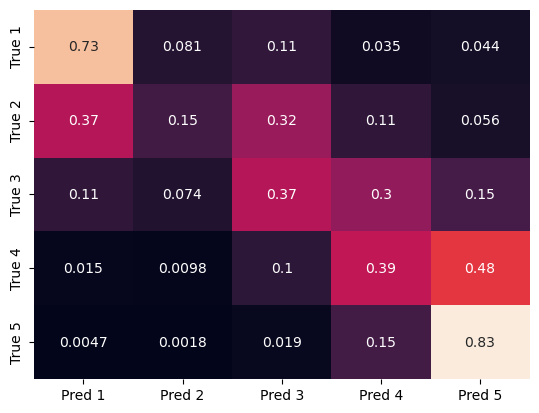

In [41]:
sns.heatmap(
    np.mean(xgb_exp_confusion, axis=0), annot=True, cbar=False,
    yticklabels=[f"True {i}" for i in range(1, 6)],
    xticklabels=[f"Pred {i}" for i in range(1, 6)]
)

## Hyperparameter Tuning

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

In [53]:
model = XGBClassifier()
results = cross_validate_params(model, "n_estimators", [100, 200, 300], X_train, y_train - 1, downsample=True, n_splits=3)

[n_estimators = 100]
CV split: 0	Time Elapsed: 0m 42s
CV split: 1	Time Elapsed: 0m 45s
CV split: 2	Time Elapsed: 0m 44s
[n_estimators = 200]
CV split: 0	Time Elapsed: 1m 28s
CV split: 1	Time Elapsed: 1m 38s
CV split: 2	Time Elapsed: 1m 37s
[n_estimators = 300]
CV split: 0	Time Elapsed: 2m 24s
CV split: 1	Time Elapsed: 2m 26s
CV split: 2	Time Elapsed: 2m 30s


In [66]:
print("Avg. CV Accuracy:        \t", [np.mean(result["accuracy"])  for result in results])
print("Average CV Cross-Entropy:\t", [np.mean(result["log_loss"])  for result in results])

Avg. CV Accuracy:        	 [0.6058204942031177, 0.6038902591845065, 0.6044655252730707]
Average CV Cross-Entropy:	 [0.9351110175606575, 0.9651024579342469, 0.9968776985156649]


In [76]:
model1 = XGBClassifier()
results1 = cross_validate_params(model1, "max_depth", [3, 6, 9], X_train, y_train - 1, downsample=True, n_splits=5)

[max_depth = 3]
CV split: 0	Time Elapsed: 0m 23s
CV split: 1	Time Elapsed: 0m 24s
CV split: 2	Time Elapsed: 0m 23s
CV split: 3	Time Elapsed: 0m 23s
CV split: 4	Time Elapsed: 0m 23s
[max_depth = 6]
CV split: 0	Time Elapsed: 0m 48s
CV split: 1	Time Elapsed: 0m 48s
CV split: 2	Time Elapsed: 0m 51s
CV split: 3	Time Elapsed: 0m 60s
CV split: 4	Time Elapsed: 0m 59s
[max_depth = 9]
CV split: 0	Time Elapsed: 2m 30s
CV split: 1	Time Elapsed: 2m 27s
CV split: 2	Time Elapsed: 2m 30s
CV split: 3	Time Elapsed: 2m 28s
CV split: 4	Time Elapsed: 2m 32s


In [77]:
print("Avg. CV Accuracy:        \t", [np.mean(result["accuracy"])  for result in results1])
print("Average CV Cross-Entropy:\t", [np.mean(result["log_loss"])  for result in results1])

Avg. CV Accuracy:        	 [0.6223035504937586, 0.6085700494553317, 0.6020551173651245]
Average CV Cross-Entropy:	 [0.9092854891105105, 0.930850346139291, 1.0019418484164127]


In [74]:
model2 = XGBClassifier(n_jobs=-1)
results2 = cross_validate_params(model2, "colsample_bytree", [0.2, 0.5, 0.7], X_train, y_train - 1, downsample=True, n_splits=5)

[colsample_bytree = 0.2]
CV split: 0	Time Elapsed: 0m 37s
CV split: 1	Time Elapsed: 0m 39s
CV split: 2	Time Elapsed: 0m 40s
CV split: 3	Time Elapsed: 0m 42s
CV split: 4	Time Elapsed: 1m 2s
[colsample_bytree = 0.5]
CV split: 0	Time Elapsed: 1m 1s
CV split: 1	Time Elapsed: 0m 57s
CV split: 2	Time Elapsed: 0m 55s
CV split: 3	Time Elapsed: 0m 56s
CV split: 4	Time Elapsed: 0m 53s
[colsample_bytree = 0.7]
CV split: 0	Time Elapsed: 0m 57s
CV split: 1	Time Elapsed: 0m 58s
CV split: 2	Time Elapsed: 0m 57s
CV split: 3	Time Elapsed: 0m 56s
CV split: 4	Time Elapsed: 0m 57s


In [75]:
print("Avg. CV Accuracy:        \t", [np.mean(result["accuracy"])  for result in results2])
print("Average CV Cross-Entropy:\t", [np.mean(result["log_loss"])  for result in results2])

Avg. CV Accuracy:        	 [0.6097934823509757, 0.6093323149588524, 0.6079076210530207]
Average CV Cross-Entropy:	 [0.9240739220728363, 0.9271764439249395, 0.9299379875889437]


In [7]:
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=123)

clf_xgb = XGBClassifier()
param_dist = {
    'n_estimators': stats.randint(150, 1000),
    'learning_rate': stats.uniform(0.01, 0.59),
    'subsample': stats.uniform(0.3, 0.6),
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'colsample_bytree': stats.uniform(0.5, 0.4),
    'min_child_weight': [1, 2, 3, 4]
}

clf = RandomizedSearchCV(
    clf_xgb,
    param_distributions = param_dist,
    cv = cv,
    n_iter = 5,
    scoring = 'neg_log_loss',
    error_score = 0,
    verbose = 3
)

In [8]:
clf.fit(X_train, y_train - 1)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2] END colsample_bytree=0.789384658213034, learning_rate=0.5388463804262557, max_depth=4, min_child_weight=3, n_estimators=488, subsample=0.5806228170413109;, score=-0.720 total time=12.3min
[CV 2/2] END colsample_bytree=0.789384658213034, learning_rate=0.5388463804262557, max_depth=4, min_child_weight=3, n_estimators=488, subsample=0.5806228170413109;, score=-0.719 total time=12.0min
[CV 1/2] END colsample_bytree=0.8171519177768172, learning_rate=0.5401908716130828, max_depth=4, min_child_weight=2, n_estimators=272, subsample=0.6678203211535156;, score=-0.689 total time= 6.4min
[CV 2/2] END colsample_bytree=0.8171519177768172, learning_rate=0.5401908716130828, max_depth=4, min_child_weight=2, n_estimators=272, subsample=0.6678203211535156;, score=-0.686 total time= 6.4min
[CV 1/2] END colsample_bytree=0.5507651338142405, learning_rate=0.13931274790095394, max_depth=7, min_child_weight=1, n_estimators=997, subsample=0.88

RandomizedSearchCV(cv=StratifiedKFold(n_splits=2, random_state=123, shuffle=True),
                   error_score=0,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_polic...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x3d49e7290>,
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x3d4d94590>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x3d41d6310>},
                   scoring='neg_log_loss', verbose=3)

In [9]:
clf.best_params_

{'colsample_bytree': 0.8171519177768172,
 'learning_rate': 0.5401908716130828,
 'max_depth': 4,
 'min_child_weight': 2,
 'n_estimators': 272,
 'subsample': 0.6678203211535156}

In [15]:
cv = StratifiedKFold(n_splits=11, shuffle=True, random_state=123)

xgb_best_params = {
    'colsample_bytree': 0.8171519177768172,
    'learning_rate': 0.5401908716130828,
    'max_depth': 4,
    'min_child_weight': 2,
    'n_estimators': 272,
    'subsample': 0.6678203211535156,
}

xgb_best = XGBClassifier(**xgb_best_params)

xgb_best_metrics = {
    "confusion": [],
    "accuracy": [],
    "log_loss": [],
}

for i, (train_indices, test_indices) in enumerate(cv.split(X_train, y_train)):
    start = time.time()
    print(f"CV split: {i}", end="\t")

    X_tt, y_tt = X_train.iloc[train_indices], y_train.iloc[train_indices]
    X_ho, y_ho = X_train.iloc[test_indices], y_train.iloc[test_indices]

    xgb_best.fit(X_tt, y_tt - 1)

    y_true = y_ho - 1
    y_pred = xgb_best.predict(X_ho)

    xgb_best_metrics["confusion"].append(confusion_matrix(y_true, y_pred, normalize="true"))
    xgb_best_metrics["accuracy"].append(accuracy_score(y_true, y_pred))
    xgb_best_metrics["log_loss"].append(log_loss(y_true, xgb_best.predict_proba(X_ho)))

    elapsed = time.time() - start
    print(f"Time Elapsed: {elapsed // 60:.0f}m {elapsed % 60:.0f}s")

CV split: 0	Time Elapsed: 10m 8s
CV split: 1	Time Elapsed: 10m 16s
CV split: 2	Time Elapsed: 11m 5s
CV split: 3	Time Elapsed: 12m 23s
CV split: 4	Time Elapsed: 15m 13s
CV split: 5	Time Elapsed: 13m 14s
CV split: 6	Time Elapsed: 15m 1s
CV split: 7	Time Elapsed: 15m 23s
CV split: 8	Time Elapsed: 20m 17s
CV split: 9	Time Elapsed: 16m 5s
CV split: 10	Time Elapsed: 15m 27s


In [16]:
np.array(xgb_best_metrics["accuracy"]).mean(), np.array(xgb_best_metrics["log_loss"]).mean()

(0.7359511374711633, 0.6692335020067411)

<Axes: >

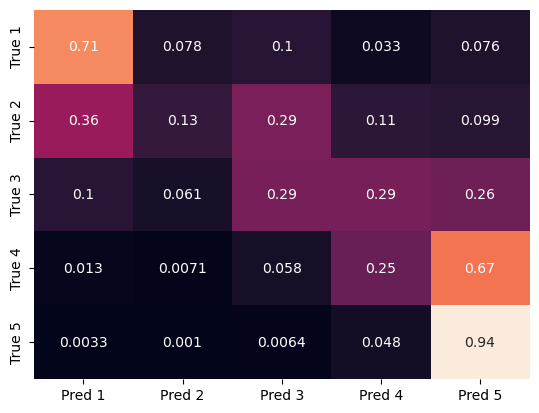

In [17]:
sns.heatmap(
    np.mean(xgb_best_metrics["confusion"], axis=0), annot=True, cbar=False,
    yticklabels=[f"True {i}" for i in range(1, 6)],
    xticklabels=[f"Pred {i}" for i in range(1, 6)]
)

## Splitting Rating into Sentiment and Intensity

In [11]:
# 1 if rating is > 3, -1 if it is < 3, and 0 if it is 3.
sentiment_train = (y_train - 3).apply(lambda r: r if abs(r) == 1 else r // 2)

In [48]:
# 1 if rating is => 3, 0 otherwise.
simple_sentiment_train = 1 * (y_train >= 3)

In [12]:
# 1 if rating is 5 star and 0 if it is 4 stars
positive_train = (y_train[y_train > 3] - 4)

In [13]:
# 1 if rating is 1 star and 0 if it is 2 stars
negative_train = (2 - y_train[y_train < 3])

### Sentiment Model (Positive, Neutral, Negative)

In [60]:
cv = StratifiedKFold(n_splits=11, shuffle=True, random_state=123)
sampler = RandomUnderSampler(random_state=123)
log_sentiment_reg = LogisticRegression(solver="newton-cg")

log_sentiment_confusion = []
log_sentiment_accs = []
log_sentiment_log_loss = []

for i, (train_indices, test_indices) in enumerate(cv.split(X_train, sentiment_train)):
    start = time.time()
    print(f"CV split: {i}", end="\t")

    X_tt, sentiment_tt = X_train.iloc[train_indices], sentiment_train.iloc[train_indices]
    X_ho, sentiment_ho = X_train.iloc[test_indices], sentiment_train.iloc[test_indices]

    X_td, sentiment_td = sampler.fit_resample(X_tt, sentiment_tt)
    log_sentiment_reg.fit(X_td, sentiment_td)
    sentiment_pred = log_sentiment_reg.predict(X_ho)

    log_sentiment_confusion.append(confusion_matrix(sentiment_ho, sentiment_pred, normalize="true"))
    log_sentiment_accs.append(accuracy_score(sentiment_ho, sentiment_pred))
    log_sentiment_log_loss.append(log_loss(sentiment_ho, log_sentiment_reg.predict_proba(X_ho)))

    elapsed = time.time() - start
    print(f"Time Elapsed: {elapsed // 60:.0f}m {elapsed % 60:.0f}s")

CV split: 0	Time Elapsed: 0m 7s
CV split: 1	Time Elapsed: 0m 6s
CV split: 2	Time Elapsed: 0m 6s
CV split: 3	Time Elapsed: 0m 6s
CV split: 4	Time Elapsed: 0m 6s
CV split: 5	Time Elapsed: 0m 6s
CV split: 6	Time Elapsed: 0m 6s
CV split: 7	Time Elapsed: 0m 6s
CV split: 8	Time Elapsed: 0m 6s
CV split: 9	Time Elapsed: 0m 7s
CV split: 10	Time Elapsed: 0m 9s


In [62]:
print("Average CV Accuracy:      \t", np.array(log_sentiment_accs).mean())
print("Average CV Cross-Entropy: \t", np.array(log_sentiment_log_loss).mean())

Average CV Accuracy:      	 0.8283994554972086
Average CV Cross-Entropy: 	 0.46091577212256607


<Axes: >

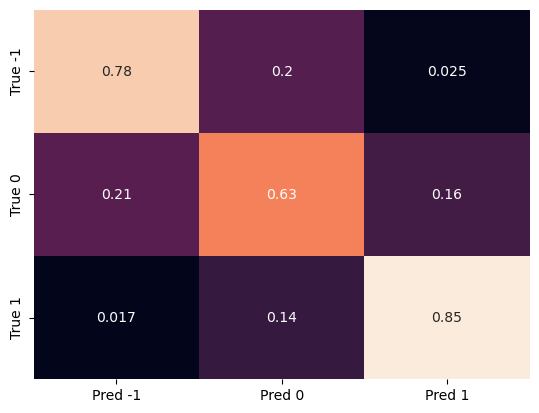

In [61]:
sns.heatmap(
    np.mean(log_sentiment_confusion, axis=0), annot=True, cbar=False,
    yticklabels=[f"True {i}" for i in range(-1, 2)],
    xticklabels=[f"Pred {i}" for i in range(-1, 2)]
)

In [14]:
xgb_sentiment_downsample = XGBClassifier()
sampler = RandomUnderSampler(random_state=123)
cv = StratifiedKFold(n_splits=11, shuffle=True, random_state=123)

xgb_sentiment_downsample_confusion = []
xgb_sentiment_downsample_acc = []
xgb_sentiment_downsample_log_loss = []

for i, (train_indices, test_indices) in enumerate(cv.split(X_train, sentiment_train)):
    start = time.time()
    print(f"CV split: {i}", end="\t")

    X_tt, y_tt = X_train.iloc[train_indices], sentiment_train.iloc[train_indices]
    X_ho, y_ho = X_train.iloc[test_indices], sentiment_train.iloc[test_indices]

    X_td, y_td = sampler.fit_resample(X_tt, y_tt)
    xgb_sentiment_downsample.fit(X_td, y_td + 1)

    y_pred = xgb_sentiment_downsample.predict(X_ho)
    y_true = y_ho + 1

    xgb_sentiment_downsample_acc.append(accuracy_score(y_true, y_pred))
    xgb_sentiment_downsample_confusion.append(confusion_matrix(y_true, y_pred, normalize="true"))
    xgb_sentiment_downsample_log_loss.append(log_loss(y_true, xgb_sentiment_downsample.predict_proba(X_ho)))

    elapsed = time.time() - start
    print(f"Time Elapsed: {elapsed // 60:.0f}m {elapsed % 60:.0f}s")

CV split: 0	Time Elapsed: 0m 41s
CV split: 1	Time Elapsed: 0m 43s
CV split: 2	Time Elapsed: 0m 44s
CV split: 3	Time Elapsed: 0m 43s
CV split: 4	Time Elapsed: 0m 43s
CV split: 5	Time Elapsed: 0m 43s
CV split: 6	Time Elapsed: 0m 41s
CV split: 7	Time Elapsed: 0m 42s
CV split: 8	Time Elapsed: 0m 43s
CV split: 9	Time Elapsed: 0m 52s
CV split: 10	Time Elapsed: 0m 51s


In [14]:
print("Average CV Accuracy:      \t", np.array(xgb_sentiment_downsample_acc).mean())
print("Average CV Cross-Entropy: \t", np.array(xgb_sentiment_downsample_log_loss).mean())

Average CV Accuracy:      	 0.8227577290749738
Average CV Cross-Entropy: 	 0.4632783349334554


<Axes: >

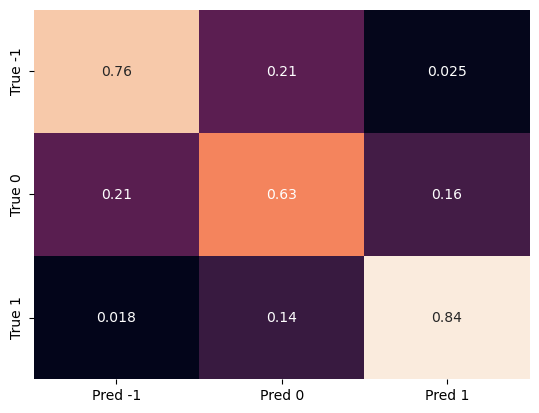

In [15]:
sns.heatmap(
    np.mean(xgb_sentiment_downsample_confusion, axis=0), annot=True, cbar=False,
    yticklabels=[f"True {i}" for i in range(-1, 2)],
    xticklabels=[f"Pred {i}" for i in range(-1, 2)]
)

In [33]:
xgb_sentiment_weighted = XGBClassifier()
cv = StratifiedKFold(n_splits=11, shuffle=True, random_state=123)

sentiment_class_weights = (sentiment_train.value_counts().min() / sentiment_train.value_counts()).sort_index()
sentiment_weights = sentiment_train.apply(lambda s: sentiment_class_weights[s])

xgb_sentiment_weighted_confusion = []
xgb_sentiment_weighted_acc = []
xgb_sentiment_weighted_log_loss = []

for i, (train_indices, test_indices) in enumerate(cv.split(X_train, sentiment_train)):
    start = time.time()
    print(f"CV split: {i}", end="\t")

    X_tt, y_tt = X_train.iloc[train_indices], sentiment_train.iloc[train_indices]
    X_ho, y_ho = X_train.iloc[test_indices], sentiment_train.iloc[test_indices]

    xgb_sentiment_weighted.fit(X_tt, y_tt + 1, sample_weight=sentiment_weights.iloc[train_indices])

    y_pred = xgb_sentiment_weighted.predict(X_ho)
    y_true = y_ho + 1

    xgb_sentiment_weighted_acc.append(accuracy_score(y_true, y_pred))
    xgb_sentiment_weighted_confusion.append(confusion_matrix(y_true, y_pred, normalize="true"))
    xgb_sentiment_weighted_log_loss.append(log_loss(y_true, xgb_sentiment_weighted.predict_proba(X_ho)))

    elapsed = time.time() - start
    print(f"Time Elapsed: {elapsed // 60:.0f}m {elapsed % 60:.0f}s")

CV split: 0	Time Elapsed: 2m 36s
CV split: 1	Time Elapsed: 3m 28s
CV split: 2	Time Elapsed: 3m 19s
CV split: 3	Time Elapsed: 3m 20s
CV split: 4	Time Elapsed: 3m 42s
CV split: 5	Time Elapsed: 3m 53s
CV split: 6	Time Elapsed: 3m 51s
CV split: 7	Time Elapsed: 3m 28s
CV split: 8	Time Elapsed: 3m 35s
CV split: 9	Time Elapsed: 3m 35s
CV split: 10	Time Elapsed: 3m 43s


In [34]:
print("Average CV Accuracy:      \t", np.array(xgb_sentiment_weighted_acc).mean())
print("Average CV Cross-Entropy: \t", np.array(xgb_sentiment_weighted_log_loss).mean())

Average CV Accuracy:      	 0.848866578503817
Average CV Cross-Entropy: 	 0.4033470342046692


<Axes: >

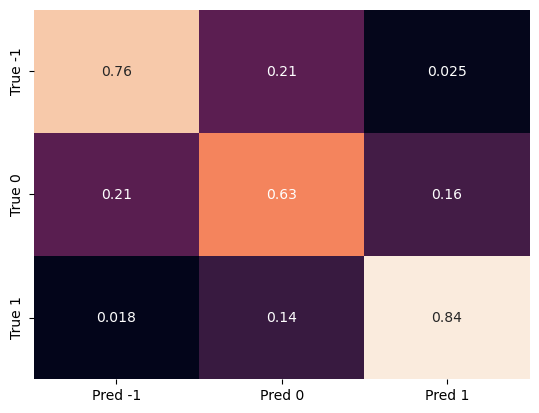

In [35]:
sns.heatmap(
    np.mean(xgb_sentiment_downsample_confusion, axis=0), annot=True, cbar=False,
    yticklabels=[f"True {i}" for i in range(-1, 2)],
    xticklabels=[f"Pred {i}" for i in range(-1, 2)]
)

### Sentiment Model (only Positive and Negative)

In [50]:
cv = StratifiedKFold(n_splits=11, shuffle=True, random_state=123)
sampler = RandomUnderSampler(random_state=123)
log_simple_reg = LogisticRegression(solver="newton-cg")

log_simple_confusion = []
log_simple_accs = []
log_simple_log_loss = []

for i, (train_indices, test_indices) in enumerate(cv.split(X_train, simple_sentiment_train)):
    start = time.time()
    print(f"CV split: {i}", end="\t")

    X_tt, y_tt = X_train.iloc[train_indices], simple_sentiment_train.iloc[train_indices]
    X_ho, y_ho = X_train.iloc[test_indices], simple_sentiment_train.iloc[test_indices]

    X_td, y_td = sampler.fit_resample(X_tt, y_tt)
    log_simple_reg.fit(X_td, y_td)
    y_pred = log_simple_reg.predict(X_ho)

    log_simple_confusion.append(confusion_matrix(y_ho, y_pred, normalize="true"))
    log_simple_accs.append(accuracy_score(y_ho, y_pred))
    log_simple_log_loss.append(log_loss(y_ho, log_simple_reg.predict_proba(X_ho)))

    elapsed = time.time() - start
    print(f"Time Elapsed: {elapsed // 60:.0f}m {elapsed % 60:.0f}s")

CV split: 0	Time Elapsed: 0m 2s
CV split: 1	Time Elapsed: 0m 2s
CV split: 2	Time Elapsed: 0m 2s
CV split: 3	Time Elapsed: 0m 2s
CV split: 4	Time Elapsed: 0m 2s
CV split: 5	Time Elapsed: 0m 2s
CV split: 6	Time Elapsed: 0m 2s
CV split: 7	Time Elapsed: 0m 2s
CV split: 8	Time Elapsed: 0m 2s
CV split: 9	Time Elapsed: 0m 2s
CV split: 10	Time Elapsed: 0m 2s


In [51]:
print("Average CV Accuracy:      \t", np.array(log_simple_accs).mean())
print("Average CV Cross-Entropy: \t", np.array(log_simple_log_loss).mean())

Average CV Accuracy:      	 0.9218081407945319
Average CV Cross-Entropy: 	 0.20579955969761105


<Axes: >

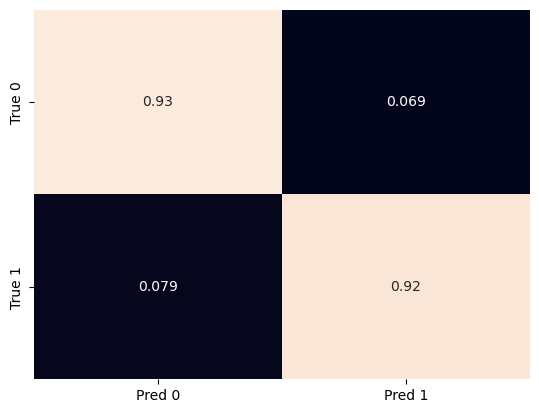

In [52]:
sns.heatmap(
    np.mean(log_simple_confusion, axis=0), annot=True, cbar=False,
    yticklabels=[f"True {i}" for i in range(2)],
    xticklabels=[f"Pred {i}" for i in range(2)]
)

In [53]:
cv = StratifiedKFold(n_splits=11, shuffle=True, random_state=123)
log_simple_reg = LogisticRegression(solver="newton-cg")

log_simple_confusion = []
log_simple_accs = []
log_simple_log_loss = []

for i, (train_indices, test_indices) in enumerate(cv.split(X_train, simple_sentiment_train)):
    start = time.time()
    print(f"CV split: {i}", end="\t")

    X_tt, y_tt = X_train.iloc[train_indices], simple_sentiment_train.iloc[train_indices]
    X_ho, y_ho = X_train.iloc[test_indices], simple_sentiment_train.iloc[test_indices]

    log_simple_reg.fit(X_tt, y_tt)
    y_pred = log_simple_reg.predict(X_ho)

    log_simple_confusion.append(confusion_matrix(y_ho, y_pred, normalize="true"))
    log_simple_accs.append(accuracy_score(y_ho, y_pred))
    log_simple_log_loss.append(log_loss(y_ho, log_simple_reg.predict_proba(X_ho)))

    elapsed = time.time() - start
    print(f"Time Elapsed: {elapsed // 60:.0f}m {elapsed % 60:.0f}s")

CV split: 0	Time Elapsed: 0m 30s
CV split: 1	Time Elapsed: 0m 26s
CV split: 2	Time Elapsed: 0m 23s
CV split: 3	Time Elapsed: 0m 23s
CV split: 4	Time Elapsed: 0m 25s
CV split: 5	Time Elapsed: 0m 25s
CV split: 6	Time Elapsed: 0m 28s
CV split: 7	Time Elapsed: 0m 26s
CV split: 8	Time Elapsed: 0m 22s
CV split: 9	Time Elapsed: 0m 21s
CV split: 10	Time Elapsed: 0m 26s


In [56]:
print("Average CV Accuracy:      \t", np.array(log_simple_accs).mean())
print("Average CV Cross-Entropy: \t", np.array(log_simple_log_loss).mean())

Average CV Accuracy:      	 0.9629198798972897
Average CV Cross-Entropy: 	 0.09315990587103987


In [64]:
import matplotlib.pyplot as plt

[Text(0.5, 23.52222222222222, 'Predicted Label'),
 Text(50.722222222222214, 0.5, 'True Label')]

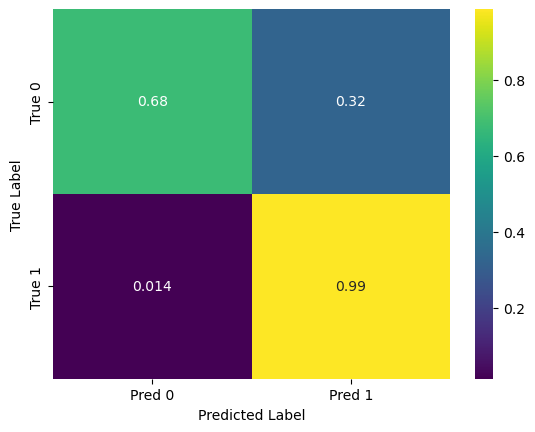

In [74]:
ax = sns.heatmap(
    np.mean(log_simple_confusion, axis=0), annot=True,
    yticklabels=[f"True {i}" for i in range(2)],
    xticklabels=[f"Pred {i}" for i in range(2)],
    cmap="viridis"
)
ax.set(xlabel="Predicted Label", ylabel="True Label")

## Final Models

In [107]:
X_test = pd.DataFrame(np.vstack(df_test["vector"].tolist()))
y_test = df_test["rating"]

In [126]:
def final_training(model, X, y, downsampled=False, random_state=123, sample_weight=None):
    sampler = RandomUnderSampler(random_state=random_state)
    X_t, y_t = sampler.fit_resample(X, y) if downsampled else (X, y)

    model.fit(X_t, y_t, sample_weight=sample_weight)
    return model

In [122]:
def show_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)

    results = {
        "confusion": confusion_matrix(y_test, y_pred, normalize="true"),
        "accuracy": accuracy_score(y_test, y_pred),
        "log_loss": log_loss(y_test, model.predict_proba(X_test)),
    }

    print("Accuracy:     \t", results["accuracy"])
    print("Cross-Entropy:\t", results["log_loss"])

    ax = sns.heatmap(
        results["confusion"], annot=True,
        yticklabels=list(range(1, 6)),
        xticklabels=list(range(1, 6)),
        cmap="viridis", vmin=0.0, vmax=1.0,
    )
    ax.set(xlabel="Predicted Label", ylabel="True Label")

In [ ]:
def save_model(model):
    model.save_model("")

### XGBoost downsampled to minority class

In [127]:
xgb_downsample_std_final = XGBClassifier()
final_training(xgb_downsample_std_final, X_train, y_train - 1, downsampled=True)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Accuracy:     	 0.6129923805418563
Cross-Entropy:	 0.9195707508847032


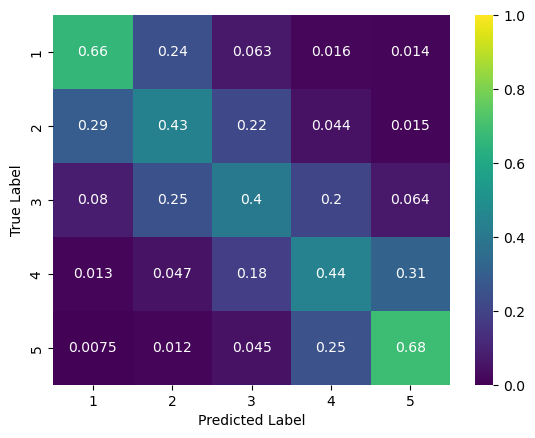

In [128]:
show_metrics(xgb_downsample_std_final, X_test, y_test - 1)

In [129]:
xgb_downsample_std_final.save_model("models/xgb_downsample_std_final.json")

### XGBoost (no downsampling)

In [121]:
xgb_std_final = XGBClassifier()
final_training(xgb_std_final, X_train, y_train - 1, downsampled=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Accuracy:     	 0.7402221179811606
Cross-Entropy:	 0.6532138973261327


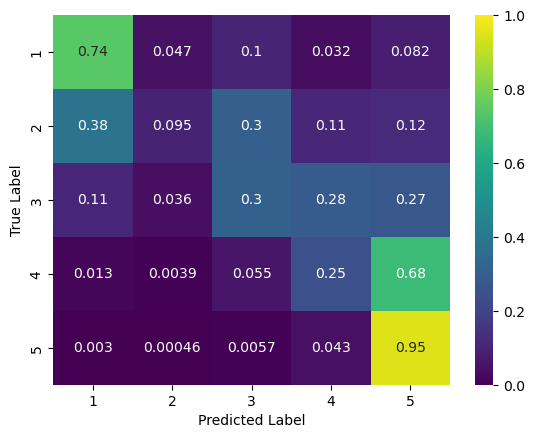

In [123]:
show_metrics(xgb_std_final, X_test, y_test - 1)

In [125]:
xgb_std_final.save_model("models/xgb_std_final.json")

### XGBoost (using sample weights)

In [144]:
xgb_weighted_std_final = XGBClassifier()
final_training(xgb_weighted_std_final, X_train, y_train - 1, sample_weight=weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Accuracy:     	 0.6463607895837823
Cross-Entropy:	 0.8501629725394296


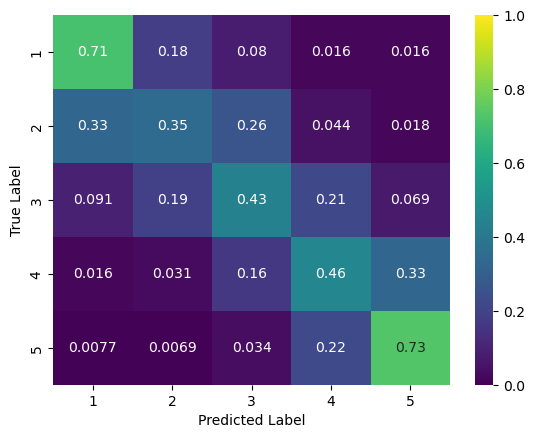

In [145]:
show_metrics(xgb_weighted_std_final, X_test, y_test - 1)

In [146]:
xgb_weighted_std_final.save_model("models/xgb_weighted_std_final.json")

### XGBoost (using RandomSearchCV parameters)

In [ ]:
xgb_optimal_final = XGBClassifier()
final_training(xgb_optimal_final, X_train, y_train - 1, sample_weight=weights)